# K_means

culmen_length_mm: culmen length (mm)

culmen_depth_mm: culmen depth (mm)

flipper_length_mm: flipper length (mm)

body_mass_g: body mass (g)

sex: penguin sex

In [46]:
import warnings
warnings.filterwarnings("ignore")
import time
from glob import glob
import os 
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, LabelEncoder
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples, adjusted_rand_score








print('Виртуальное окружение')
!which python 
# Текущее положение
print('\nТекущее положение: ')
path_1 = os.getcwd()
print(path_1)

Виртуальное окружение
/home/maksim/anaconda3/envs/rapids-25.02/bin/python

Текущее положение: 
/home/maksim/develops/python/MAKSIM/ML/10_k_means


## 1) Загрузка

In [47]:
train_df = pd.read_csv('train.csv')


print('\nРазмер данных: ', train_df.shape)

print(train_df.head().to_string(index=False))



Размер данных:  (344, 5)
 culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g    sex
             39.1             18.7              181.0       3750.0   MALE
             39.5             17.4              186.0       3800.0 FEMALE
             40.3             18.0              195.0       3250.0 FEMALE
              NaN              NaN                NaN          NaN    NaN
             36.7             19.3              193.0       3450.0 FEMALE


## 2) Анализ

In [48]:
# EDA: Исследование данных
print(train_df.info())
print(train_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   culmen_length_mm   342 non-null    float64
 1   culmen_depth_mm    342 non-null    float64
 2   flipper_length_mm  342 non-null    float64
 3   body_mass_g        342 non-null    float64
 4   sex                335 non-null    object 
dtypes: float64(4), object(1)
memory usage: 13.6+ KB
None
       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        342.000000       342.000000         342.000000   342.000000
mean          43.921930        17.151170         214.014620  4201.754386
std            5.459584         1.974793         260.558057   801.954536
min           32.100000        13.100000        -132.000000  2700.000000
25%           39.225000        15.600000         190.000000  3550.000000
50%           44.450000        17.300000         197.000000  405

In [49]:
print("\nПропуски:")
print(train_df.isnull().sum())
print("\nУникальные значения:")
print(train_df['sex'].unique())


Пропуски:
culmen_length_mm     2
culmen_depth_mm      2
flipper_length_mm    2
body_mass_g          2
sex                  9
dtype: int64

Уникальные значения:
['MALE' 'FEMALE' nan '.']


In [50]:
# Удаление некорректных значений в столбце 'sex'
train_df = train_df[train_df['sex'].isin(['MALE', 'FEMALE'])]
print('\nРазмер данных: ', train_df.shape)
print("\nПропуски:")
print(train_df.isnull().sum())
print("\nУникальные значения в sex:")
print(train_df['sex'].unique())
print(train_df[:5])
# Удаление некорректных значений в столбце 'flipper_length_mm'
train_df = train_df[(train_df['flipper_length_mm'] > 0) & (train_df['flipper_length_mm'] <= 300)]
# Кодирование категориального признака
train_df['sex'] = LabelEncoder().fit_transform(train_df['sex'])
print("\nУникальные значения в flipper_length_mm:")
print(train_df['flipper_length_mm'].unique())
train_df


Размер данных:  (334, 5)

Пропуски:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64

Уникальные значения в sex:
['MALE' 'FEMALE']
   culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g     sex
0              39.1             18.7              181.0       3750.0    MALE
1              39.5             17.4              186.0       3800.0  FEMALE
2              40.3             18.0              195.0       3250.0  FEMALE
4              36.7             19.3              193.0       3450.0  FEMALE
5              39.3             20.6              190.0       3650.0    MALE

Уникальные значения в flipper_length_mm:
[181. 186. 195. 193. 190. 182. 191. 185. 197. 184. 194. 174. 180. 189.
 187. 183. 172. 178. 188. 196. 200. 192. 198. 202. 205. 208. 203. 199.
 176. 210. 201. 212. 206. 207. 211. 230. 218. 215. 219. 209. 214. 216.
 213. 217. 221. 222. 220. 225. 224. 231. 229. 223. 228. 226.]


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,1
1,39.5,17.4,186.0,3800.0,0
2,40.3,18.0,195.0,3250.0,0
4,36.7,19.3,193.0,3450.0,0
5,39.3,20.6,190.0,3650.0,1
...,...,...,...,...,...
338,47.2,13.7,214.0,4925.0,0
340,46.8,14.3,215.0,4850.0,0
341,50.4,15.7,222.0,5750.0,1
342,45.2,14.8,212.0,5200.0,0


## 3) Кластеризация

In [51]:

features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
X = train_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_score = -1
best_params = {}
silhouette_scores = []
for n_clusters in range(2, 11):
    for init_method in ['k-means++', 'random']:
        for max_iter in [50, 100, 150]:
            for algorithm in ['full', 'elkan']:
                try:

                    kmeans = KMeans(n_clusters=n_clusters, init=init_method, max_iter=max_iter, algorithm=algorithm, random_state=42)
                    labels = kmeans.fit_predict(X_scaled)
                    score = silhouette_score(X_scaled, labels)
                    silhouette_scores.append((n_clusters, score))

                    
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'n_clusters': n_clusters,
                            'init': init_method,
                            'max_iter': max_iter,
                            'algorithm': algorithm
                        }
                except Exception as e:
                    continue

print(f'Лучшие параметры: {best_params}')
print(f'Лучший коэффициент силуэта: {best_score:.4f}')

for n_clusters, score in silhouette_scores:
    print(f'n_clusters={n_clusters}, silhouette_score={score:.4f}')
    
best_n_clusters, best_silhouette_score = max(silhouette_scores, key=lambda x: x[1])
print(f'Лучшее количество кластеров: {best_n_clusters}')
print(f'Лучший коэффициент силуэта: {best_silhouette_score:.4f}')

final_kmeans = KMeans(**best_params, random_state=42)
train_df['cluster'] = final_kmeans.fit_predict(X_scaled)

train_df.to_csv('train_clustered.csv', index=False)


Лучшие параметры: {'n_clusters': 6, 'init': 'random', 'max_iter': 50, 'algorithm': 'elkan'}
Лучший коэффициент силуэта: 0.5227
n_clusters=2, silhouette_score=0.4444
n_clusters=2, silhouette_score=0.4444
n_clusters=2, silhouette_score=0.4444
n_clusters=2, silhouette_score=0.4444
n_clusters=2, silhouette_score=0.4444
n_clusters=2, silhouette_score=0.4444
n_clusters=3, silhouette_score=0.4513
n_clusters=3, silhouette_score=0.4513
n_clusters=3, silhouette_score=0.4513
n_clusters=3, silhouette_score=0.4513
n_clusters=3, silhouette_score=0.4513
n_clusters=3, silhouette_score=0.4513
n_clusters=4, silhouette_score=0.5086
n_clusters=4, silhouette_score=0.5086
n_clusters=4, silhouette_score=0.5086
n_clusters=4, silhouette_score=0.5086
n_clusters=4, silhouette_score=0.5086
n_clusters=4, silhouette_score=0.5086
n_clusters=5, silhouette_score=0.4879
n_clusters=5, silhouette_score=0.4879
n_clusters=5, silhouette_score=0.4879
n_clusters=5, silhouette_score=0.5201
n_clusters=5, silhouette_score=0.5201

## 4) Метод локтя

### Убираем признак "sex", проводим кластеризацию

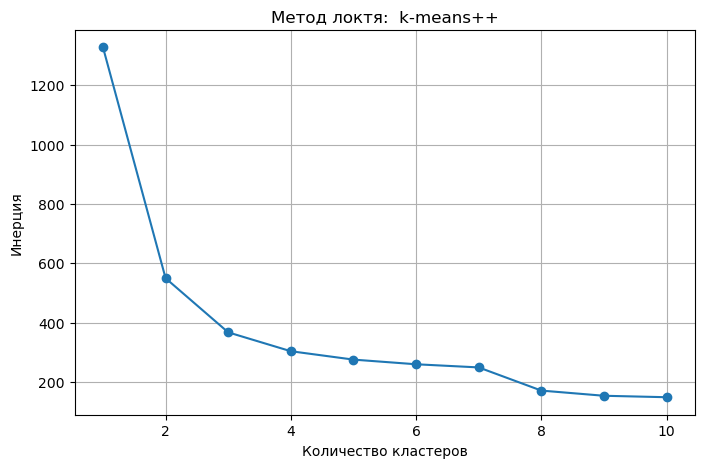

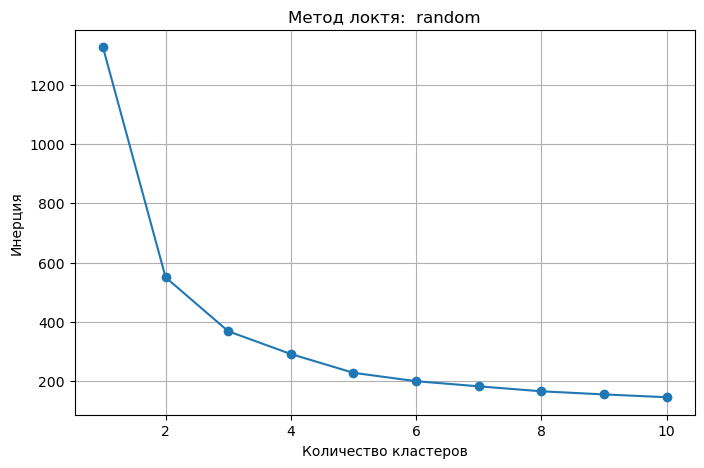

[0.0,
 -0.002643964869682548,
 0.02371386880897902,
 0.11813486352405665,
 0.14307132978290416,
 0.10040692323349873,
 0.08547245859339392,
 0.16742839922407668,
 0.15167330278833868,
 0.13542995504148223,
 0.0,
 -0.002643964869682548,
 0.02371386880897902,
 0.11992581365422729,
 0.21190650978532866,
 0.23150867338062506,
 0.20482678146249905,
 0.1793487066716738,
 0.14179332632331787,
 0.1392621938046997]

In [52]:
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = train_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
adjusted_score = []
for init_method in ['k-means++', 'random']:
    inertia = []
    for n_clusters in range(1, 11):

            kmeans = KMeans(n_clusters=n_clusters, init=init_method, max_iter=100, algorithm='lloyd', random_state=42)
            labels = kmeans.fit_predict(X_scaled)
            inertia.append(kmeans.inertia_)
            score = adjusted_rand_score(train_df['sex'], labels)
            adjusted_score.append(score)
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title(f'Метод локтя:  {init_method}')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Инерция')
    plt.grid(True)
    plt.show()
adjusted_score

## 5) Метод силуэта

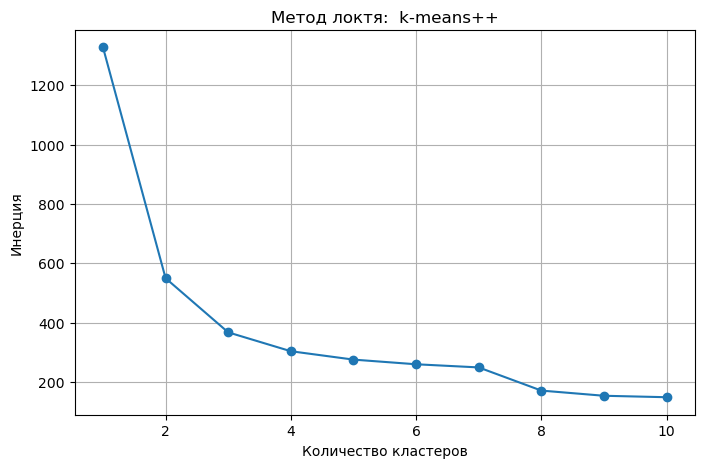

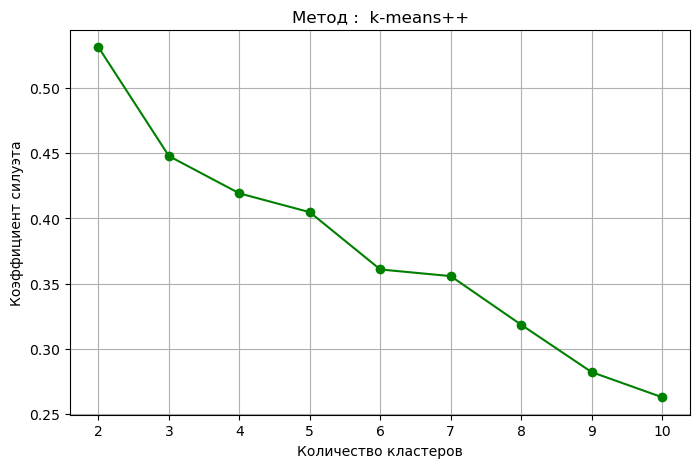

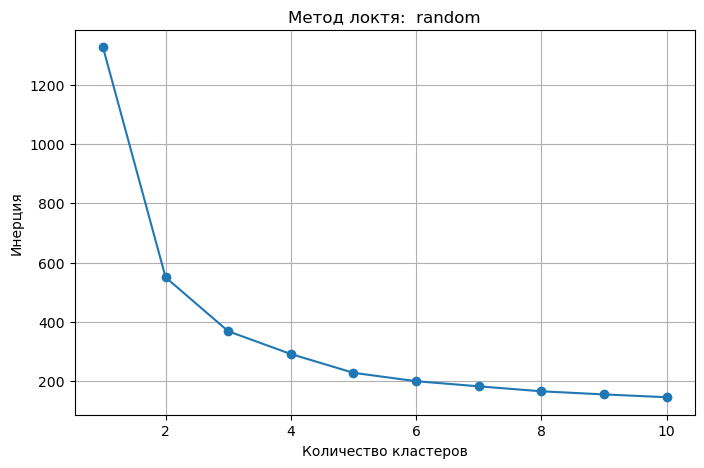

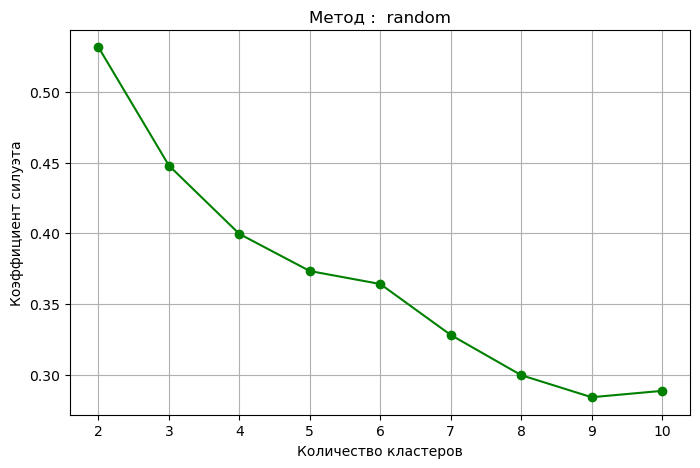

Лучшие параметры: {'n_clusters': 2, 'init': 'k-means++', 'max_iter': 100, 'algorithm': 'lloyd'}
Лучший коэффициент силуэта: 0.5314


In [53]:
# features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex']
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = train_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for init_method in ['k-means++', 'random']:
    inertia = []
    for n_clusters in range(1, 11):

            kmeans = KMeans(n_clusters=n_clusters, init=init_method, max_iter=50, algorithm='lloyd', random_state=42)
            kmeans.fit(X_scaled)
            inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), inertia, marker='o')
    plt.title(f'Метод локтя:  {init_method}')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Инерция')
    plt.grid(True)
    plt.show()

    adjusted_score =[]
    silhouette_scores = []
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, init=init_method, max_iter=100, algorithm='lloyd', random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        score = silhouette_score(X_scaled, labels)
        silhouette_scores.append(score)
        score = adjusted_rand_score(train_df['sex'], labels)
        adjusted_score.append(score)
    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 11), silhouette_scores, marker='o', color='green')
    plt.title(f'Метод :  {init_method}')
    plt.xlabel('Количество кластеров')
    plt.ylabel('Коэффициент силуэта')
    plt.grid(True)
    plt.show()

best_score = -1
best_params = {}
for n_clusters in range(2, 11):
    for init_method in ['k-means++', 'random']:
        for max_iter in [100, 300, 500]:
            for algorithm in ['lloyd', 'elkan']:
                try:
                    kmeans = KMeans(n_clusters=n_clusters, init=init_method, max_iter=max_iter, algorithm=algorithm, random_state=42)
                    labels = kmeans.fit_predict(X_scaled)
                    score = silhouette_score(X_scaled, labels)
                    
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'n_clusters': n_clusters,
                            'init': init_method,
                            'max_iter': max_iter,
                            'algorithm': algorithm
                        }
                except Exception as e:
                    continue

print(f'Лучшие параметры: {best_params}')
print(f'Лучший коэффициент силуэта: {best_score:.4f}')

final_kmeans = KMeans(**best_params, random_state=42)
train_df['cluster'] = final_kmeans.fit_predict(X_scaled)

train_df.to_csv('train_clustered.csv', index=False)


In [54]:
adjusted_score

[-0.002643964869682548,
 0.02371386880897902,
 0.11992581365422729,
 0.21190650978532866,
 0.23150867338062506,
 0.20482678146249905,
 0.1793487066716738,
 0.14179332632331787,
 0.1392621938046997]

#### Оценка  
лучшее значение при 2-х кластерах  0.5314  
совпадение  0.23150867338062506  


For n_clusters = 2, The average silhouette_score is : 0.5314
For n_clusters = 3, The average silhouette_score is : 0.4479
For n_clusters = 4, The average silhouette_score is : 0.3996
For n_clusters = 5, The average silhouette_score is : 0.3734
For n_clusters = 6, The average silhouette_score is : 0.3643
For n_clusters = 7, The average silhouette_score is : 0.3283
For n_clusters = 8, The average silhouette_score is : 0.2999
For n_clusters = 9, The average silhouette_score is : 0.2844
For n_clusters = 10, The average silhouette_score is : 0.2889


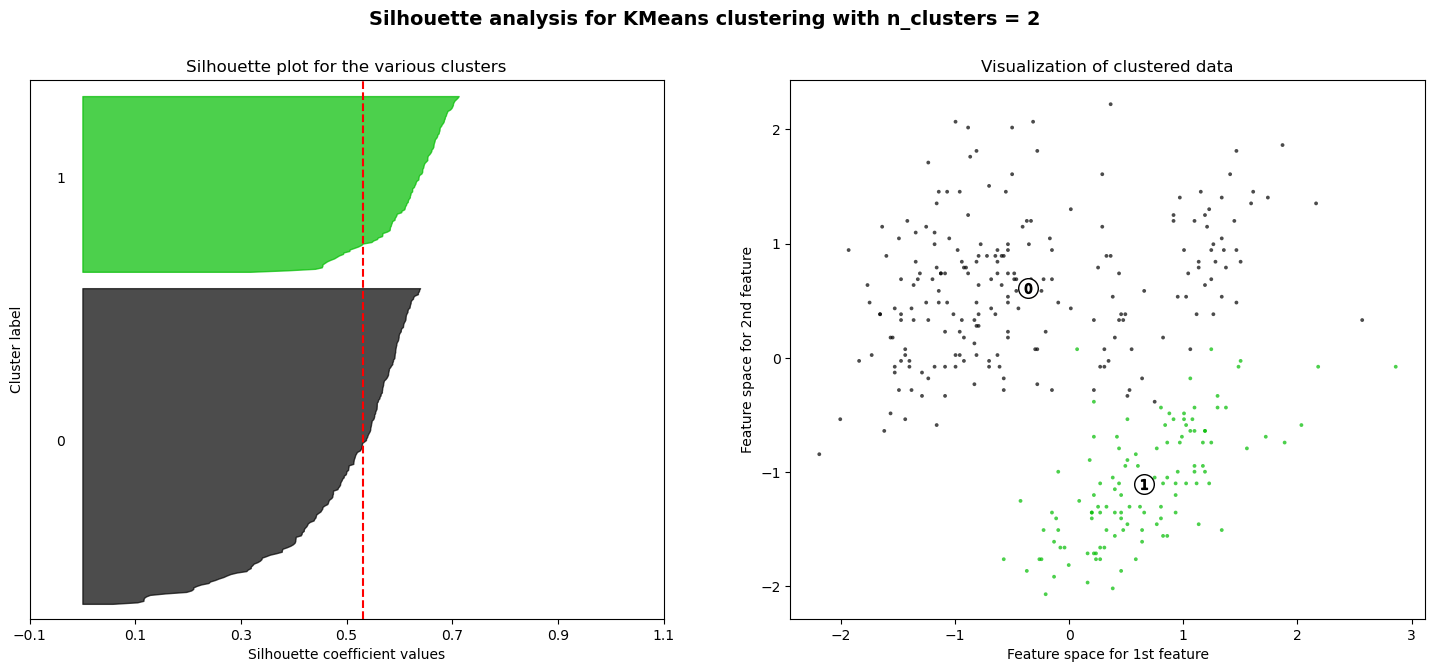

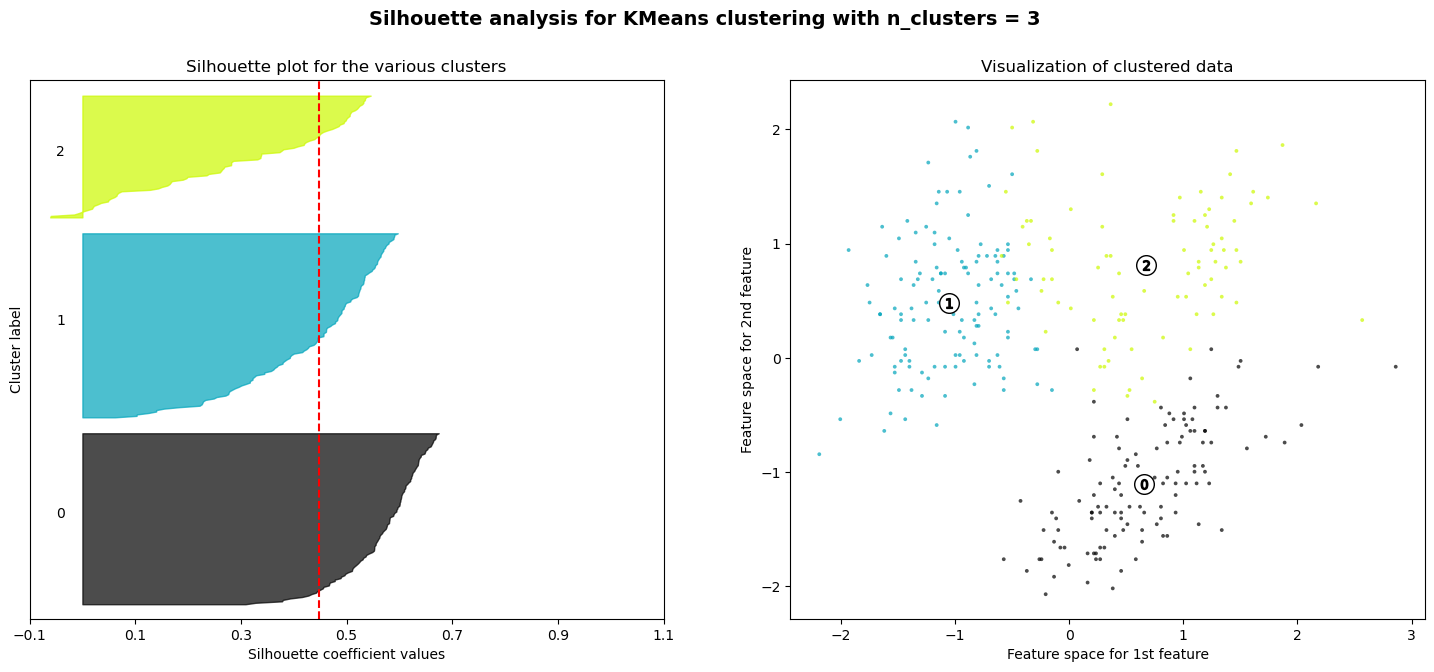

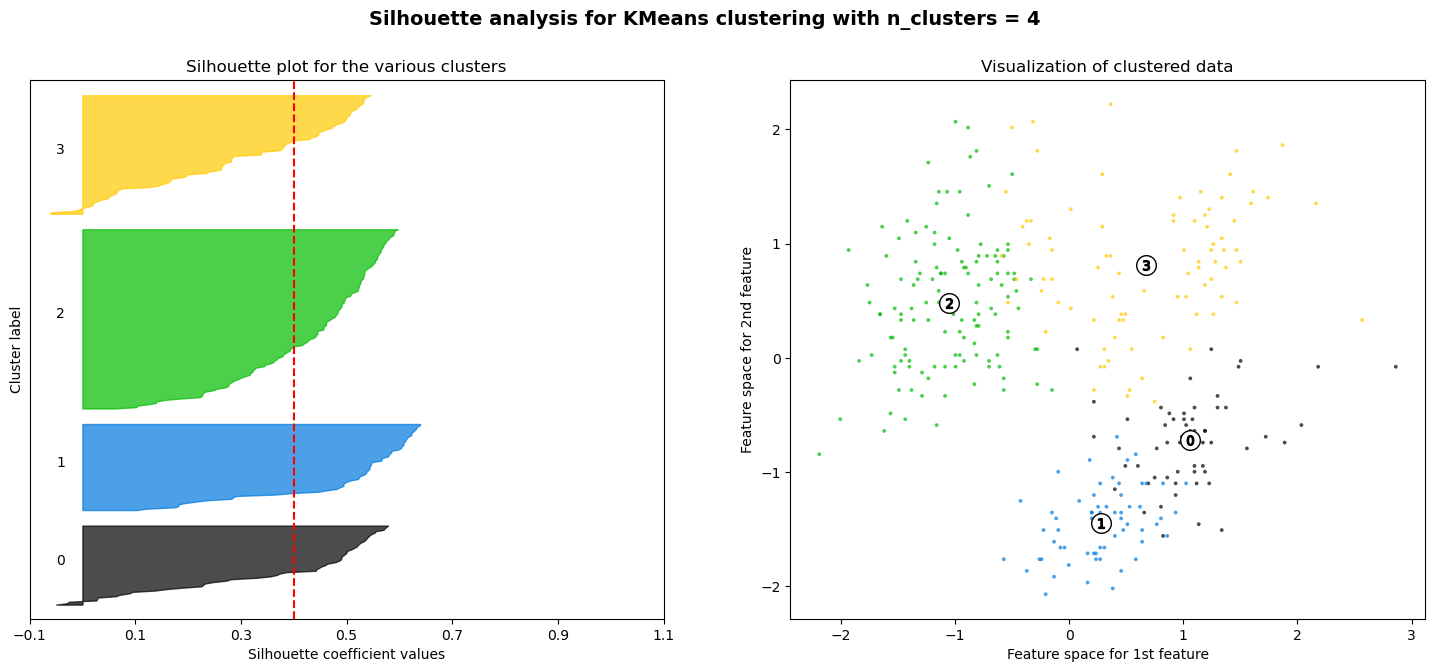

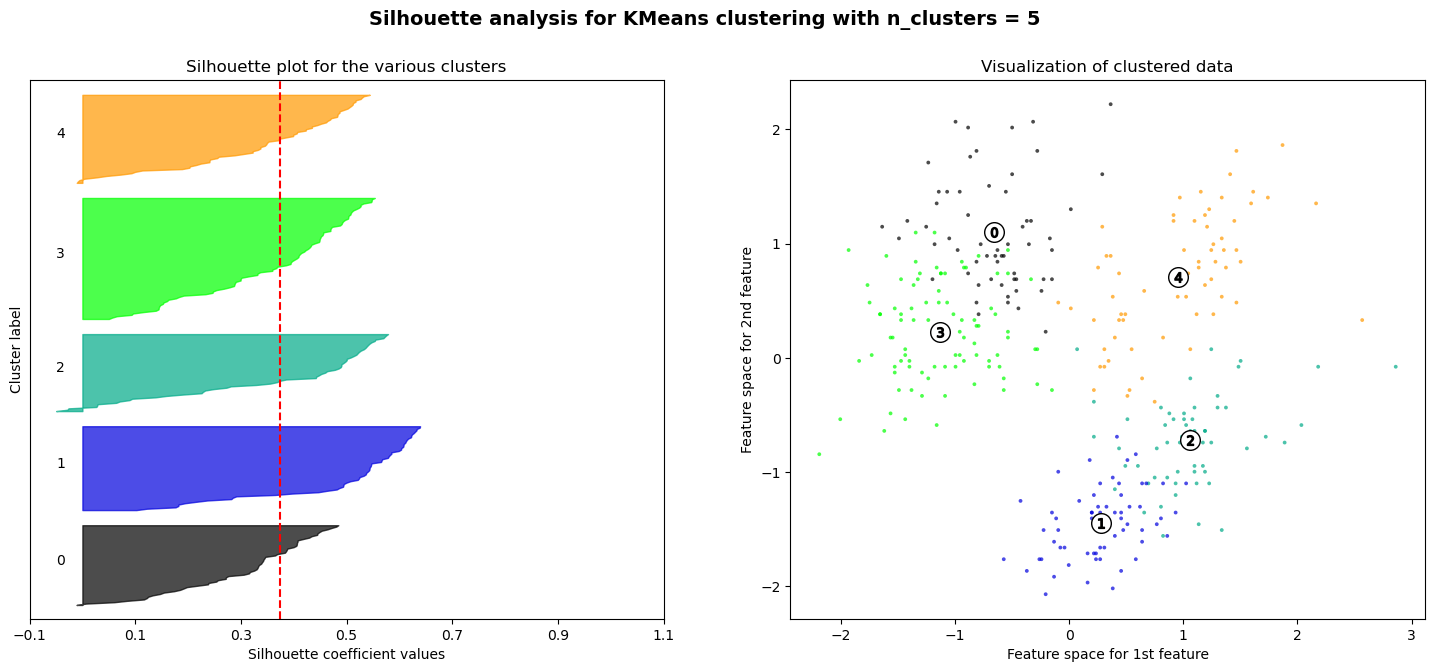

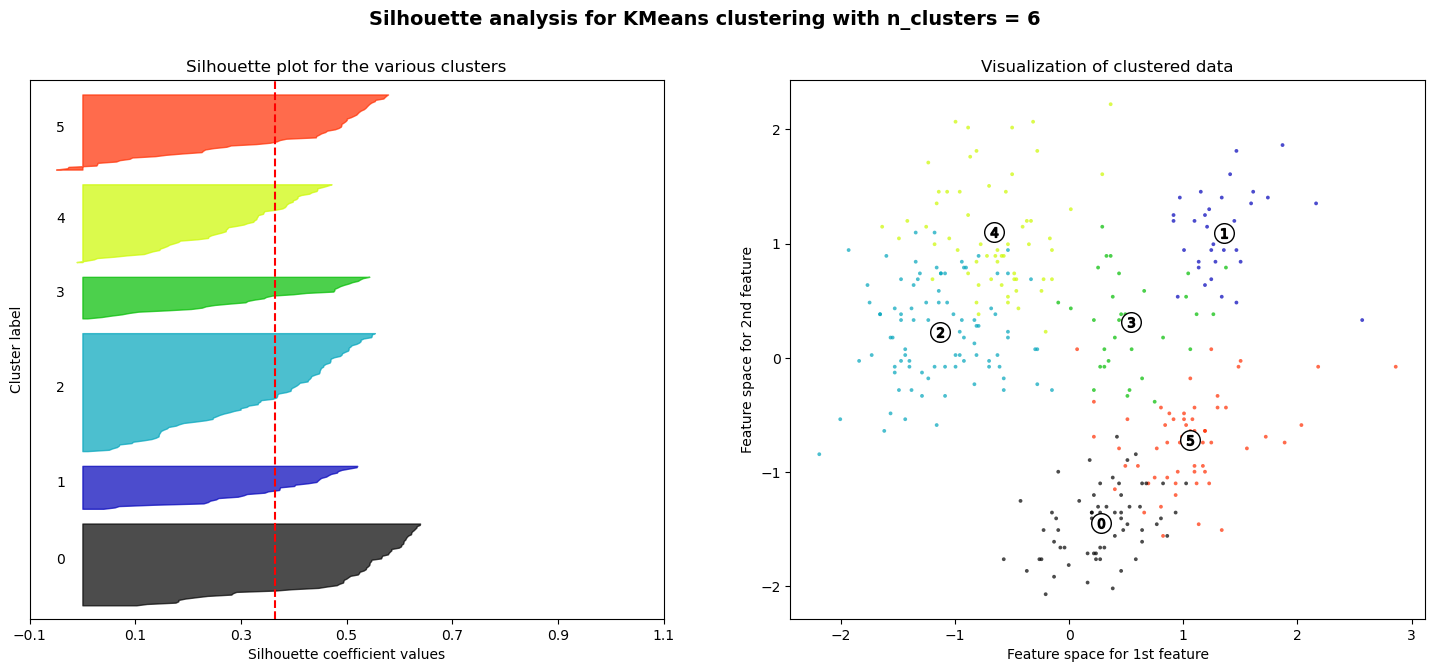

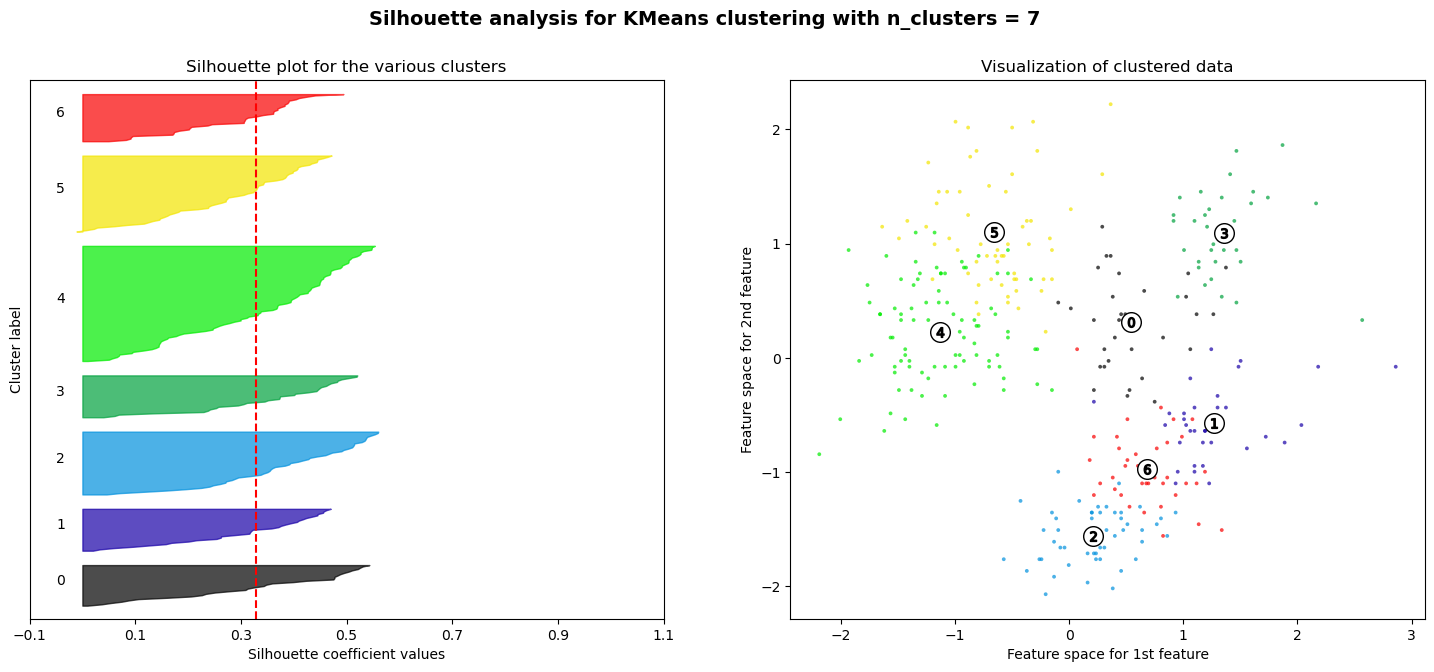

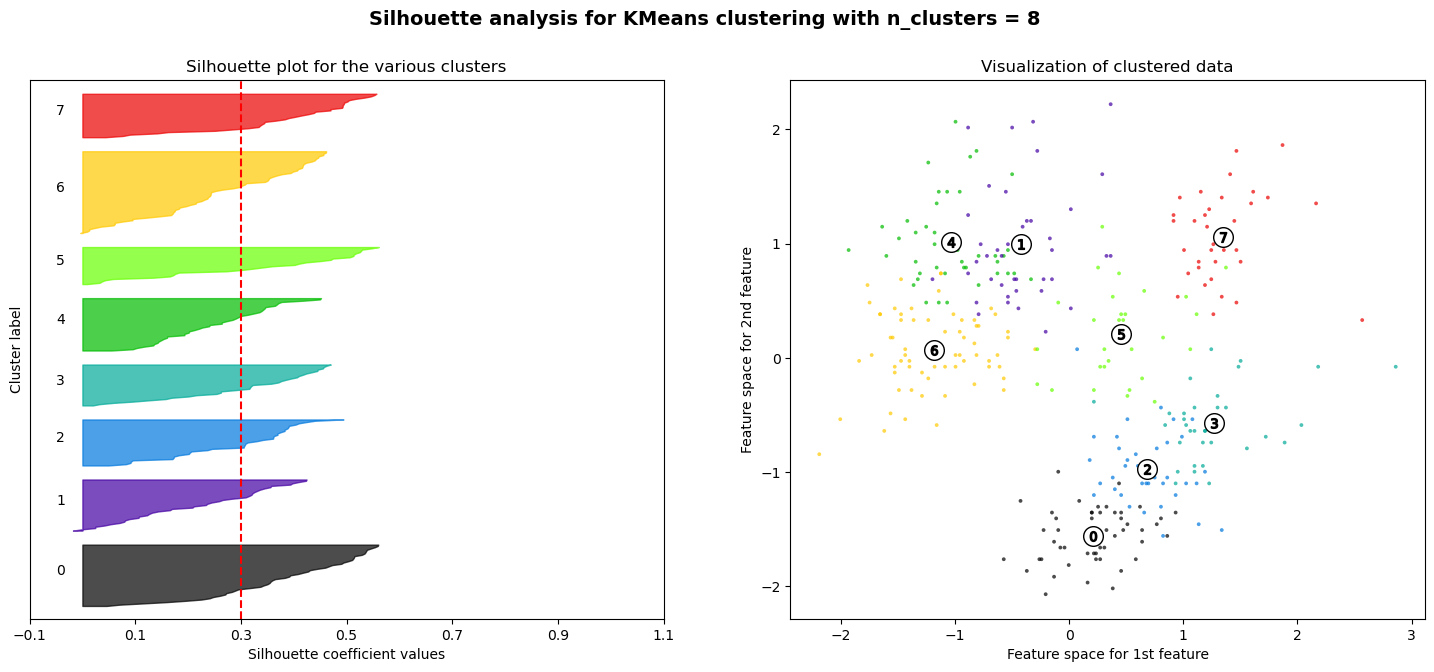

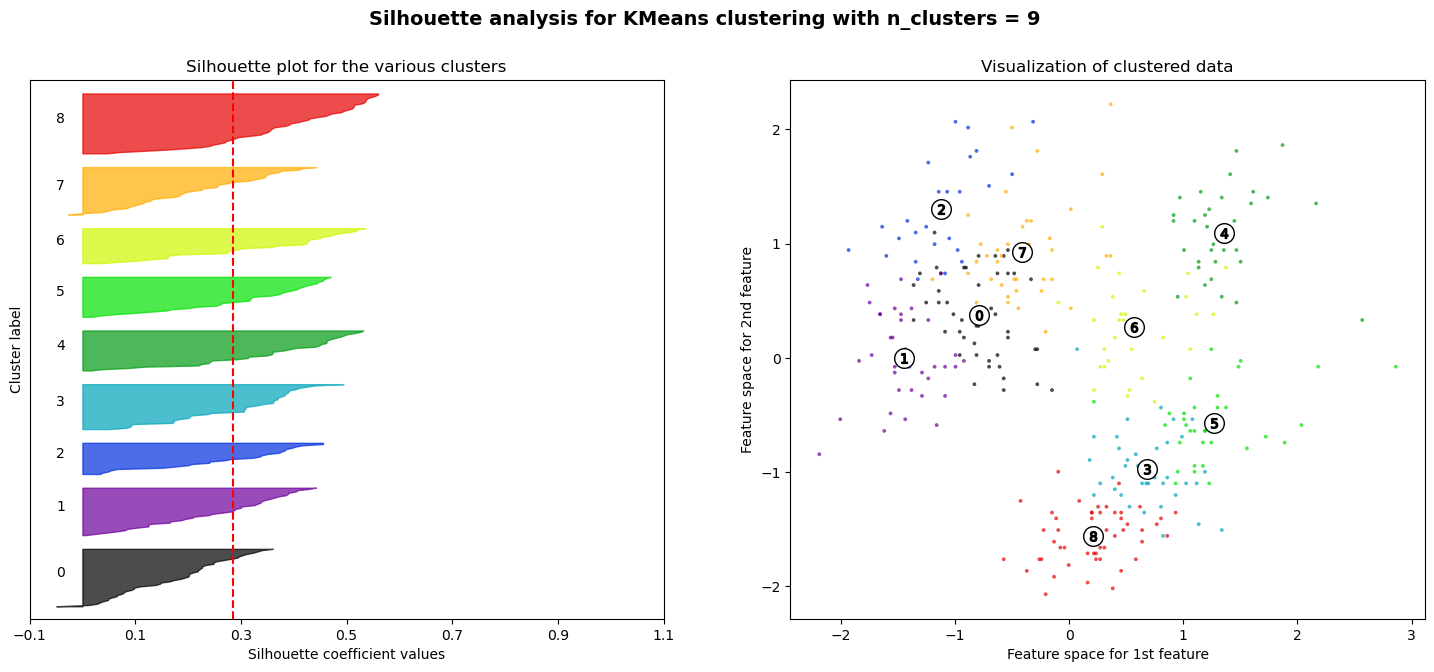

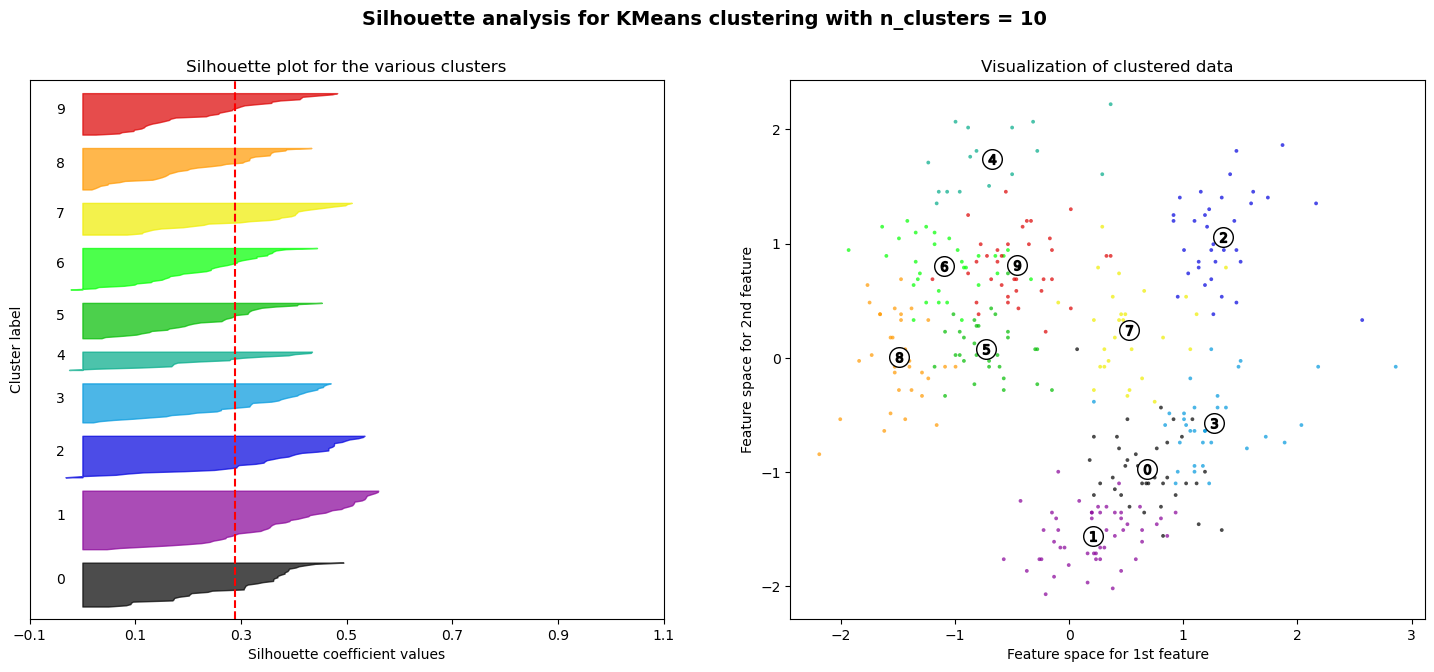

In [55]:
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = train_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

min_range = 2
max_range = 11  

for i in range(min_range, max_range):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X_scaled) + (i + 1) * 10])

    clusterer = KMeans(n_clusters=i, init='random', max_iter=50, algorithm='lloyd', random_state=42)
    cluster_labels = clusterer.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    print(f"For n_clusters = {i}, The average silhouette_score is : {silhouette_avg:.4f}")

    sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

    y_lower = 10
    for j in range(i):
        jth_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
        jth_cluster_silhouette_values.sort()

        size_cluster_j = jth_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_j

        color = cm.nipy_spectral(float(j) / i)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            jth_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))
        y_lower = y_upper + 10

    ax1.set_title("Silhouette plot for the various clusters")
    ax1.set_xlabel("Silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks(np.arange(-0.1, 1.1, 0.2))

    colors = cm.nipy_spectral(cluster_labels.astype(float) / i)
    ax2.scatter(
        X_scaled[:, 0], X_scaled[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for k, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker=f"${k}$", alpha=1, s=50, edgecolor="k")

    ax2.set_title("Visualization of clustered data")
    ax2.set_xlabel("Feature space for 1st feature")
    ax2.set_ylabel("Feature space for 2nd feature")

    plt.suptitle(
        f"Silhouette analysis for KMeans clustering with n_clusters = {i}",
        fontsize=14,
        fontweight='bold'
    )

plt.show()


## 6) Визуализация

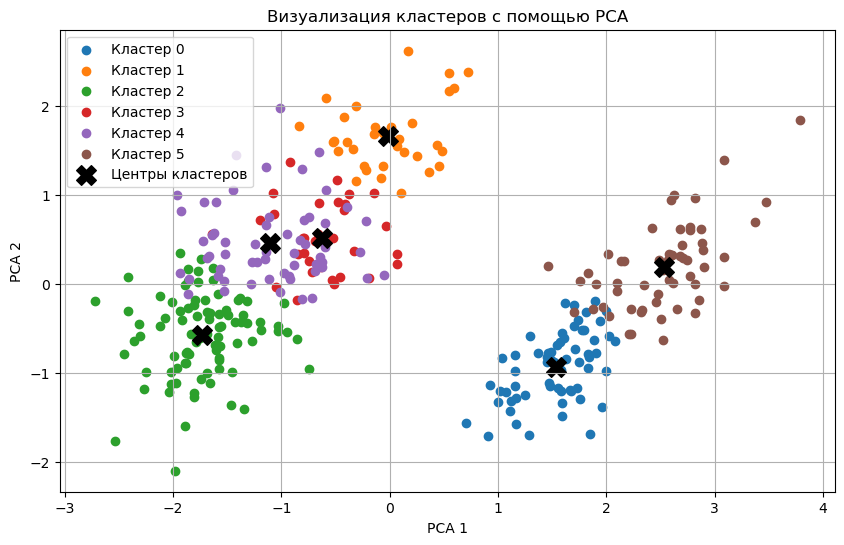

In [56]:
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = train_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_kmeans = KMeans(n_clusters=6, init='random', max_iter=50, algorithm='lloyd', random_state=42)
train_df['cluster'] = best_kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

centers_pca = pca.transform(best_kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
for cluster in range(best_kmeans.n_clusters):
    plt.scatter(X_pca[train_df['cluster'] == cluster, 0], 
                X_pca[train_df['cluster'] == cluster, 1], 
                label=f'Кластер {cluster}')

plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            s=200, c='black', marker='X', label='Центры кластеров')

plt.title('Визуализация кластеров с помощью PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()


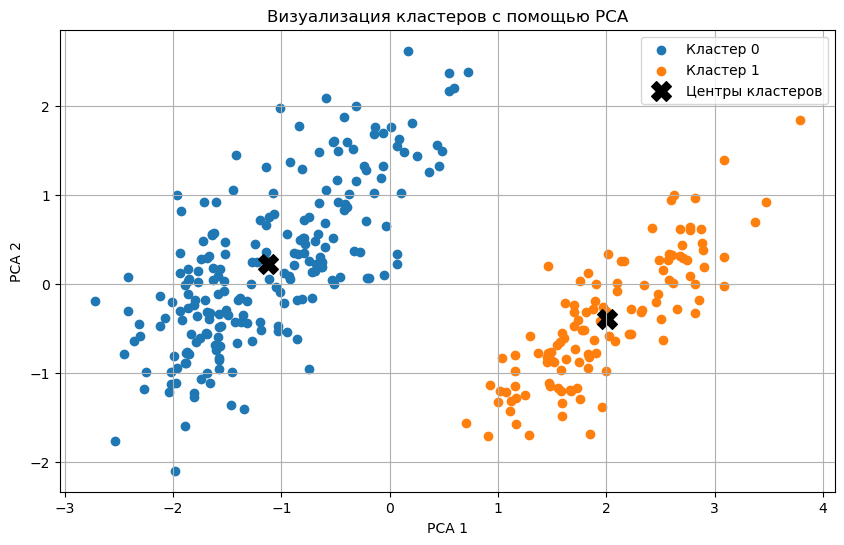

In [57]:
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = train_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_kmeans = KMeans(n_clusters=2, init='random', max_iter=50, algorithm='lloyd', random_state=42)
train_df['cluster'] = best_kmeans.fit_predict(X_scaled)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

centers_pca = pca.transform(best_kmeans.cluster_centers_)

plt.figure(figsize=(10, 6))
for cluster in range(best_kmeans.n_clusters):
    plt.scatter(X_pca[train_df['cluster'] == cluster, 0], 
                X_pca[train_df['cluster'] == cluster, 1], 
                label=f'Кластер {cluster}')

plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
            s=200, c='black', marker='X', label='Центры кластеров')

plt.title('Визуализация кластеров с помощью PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

In [58]:
features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = train_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_kmeans = KMeans(n_clusters=6, init='random', max_iter=50, algorithm='lloyd', random_state=42)
train_df['cluster'] = best_kmeans.fit_predict(X_scaled)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(best_kmeans.cluster_centers_)

train_df[['PCA1', 'PCA2', 'PCA3']] = X_pca

# Визуализация в Plotly
fig = px.scatter_3d(train_df, x='PCA1', y='PCA2', z='PCA3', 
                    color='cluster', symbol='cluster',
                    title='Визуализация кластеров с помощью PCA (3 компоненты)',
                    labels={'PCA1': 'Первая компонента', 'PCA2': 'Вторая компонента', 'PCA3': 'Третья компонента'})

fig.add_trace(go.Scatter3d(x=centers_pca[:, 0], y=centers_pca[:, 1], z=centers_pca[:, 2],
                           mode='markers', marker=dict(size=3, color='black', symbol='x'),
                           name='Центры кластеров'))

fig.update_layout(height=800)  
fig.show()


In [59]:

features = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
X = train_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

best_kmeans = KMeans(n_clusters=2, init='random', max_iter=50, algorithm='lloyd', random_state=42)
train_df['cluster'] = best_kmeans.fit_predict(X_scaled)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(best_kmeans.cluster_centers_)

train_df[['PCA1', 'PCA2', 'PCA3']] = X_pca

fig = px.scatter_3d(train_df, x='PCA1', y='PCA2', z='PCA3', 
                    color='cluster', symbol='cluster',
                    title='Визуализация кластеров с помощью PCA (3 компоненты)',
                    labels={'PCA1': 'Первая компонента', 'PCA2': 'Вторая компонента', 'PCA3': 'Третья компонента'})


fig.add_trace(go.Scatter3d(x=centers_pca[:, 0], y=centers_pca[:, 1], z=centers_pca[:, 2],
                           mode='markers', marker=dict(size=3, color='black', symbol='x'),
                           name='Центры кластеров'))

fig.update_layout(height=800) 
fig.show()

## 7) Сохранение модели

In [60]:
import joblib

joblib.dump(best_kmeans, 'kmeans_model.joblib')

print("Модель успешно сохранена в файл 'kmeans_model.joblib'")


Модель успешно сохранена в файл 'kmeans_model.joblib'
